In [157]:
%matplotlib inline
# import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.backend import square, mean
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau,EarlyStopping
from tensorflow.python.keras.initializers import RandomUniform

look_back = 4 * 24 * 4*4
num_epochs = 7
# seq_len = 4 * 2
batch_size=256
loss="mse"
ewm=8
units=256

shift_steps=4 * 8*2

warmup_steps=0

In [158]:
# def getDataset():
#     url = "./datasets/DAT_ASCII_EURUSD_M1_2018.csv"
#     df = pd.read_csv(url, names=list(["date","open", "high", "low", "close", "volume"]), header=None, sep=";")
#     df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
#     df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
#     df.set_axis(df['date'], inplace=True)
#     df.drop(columns=["date"], inplace=True)
#     df["Close"]= df["close"] # compatibility
#     df.drop(columns=['close'], inplace=True)
#     return df

In [159]:
def getDataset():
    url = "./datasets/eurusd-m15-2018/EURUSD.csv"
    df = pd.read_csv(url)
    df.drop("Volume", 1, inplace=True)
    df["Date"] = df["Date"].astype(str) + " " + df["Timestamp"]
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index("Date", inplace=True)
    # df.drop("Date", 1, inplace=True)
    df.drop("Timestamp", 1, inplace=True)
    df.drop("Open", 1, inplace=True)
    df.drop("High", 1, inplace=True)
    df.drop("Low", 1, inplace=True)

    return df

In [160]:
df = getDataset()
dflen=len(df)
df=df[:int(dflen/8)]
df.head()

,Close
Date,
2015-01-25 22:00:00,1.11380
2015-01-25 22:15:00,1.11422
2015-01-25 22:30:00,1.11482
2015-01-25 22:45:00,1.11430
2015-01-25 23:00:00,1.11425


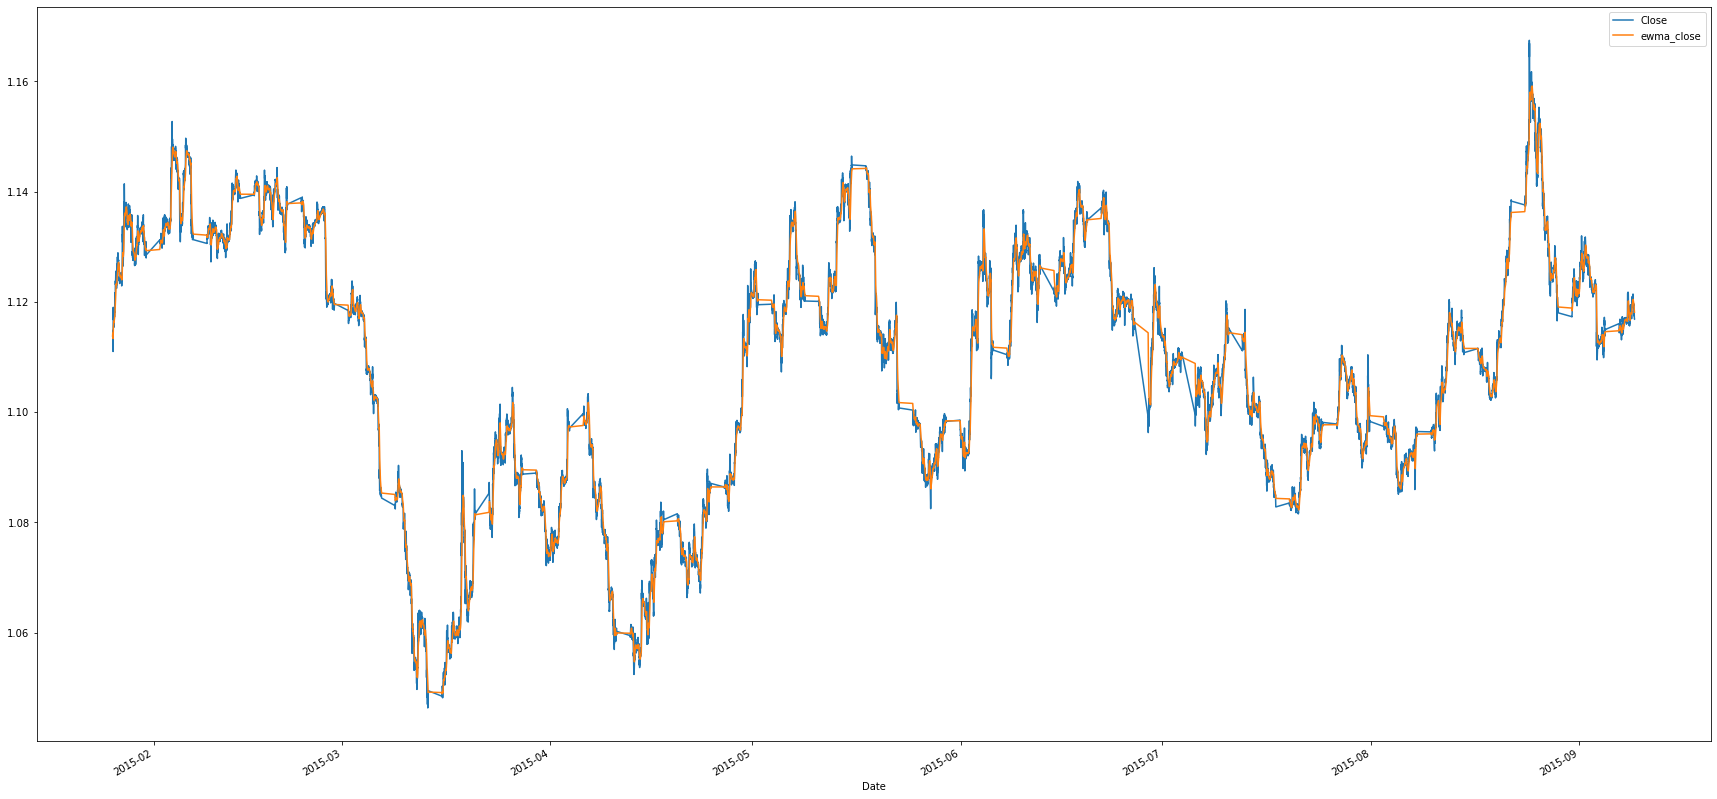

In [161]:
df["ewma_close"]=df["Close"].ewm(ewm).mean()
df.plot(figsize=(30,15))

In [162]:
df["targets"]=df["ewma_close"].shift(-shift_steps) # yeah, that minus there is realllyyyy important
df.drop(columns=["Close"], inplace=True)
print(df_targets)

Date
2015-01-25 22:00:00    1.113800
2015-01-25 22:15:00    1.114022
2015-01-25 22:30:00    1.114320
2015-01-25 22:45:00    1.114314
2015-01-25 23:00:00    1.114298
                         ...   
2015-06-25 01:15:00    1.120341
2015-06-25 01:30:00    1.120272
2015-06-25 01:45:00    1.120258
2015-06-25 02:00:00    1.120227
2015-06-25 02:15:00    1.120281
Name: ewma_close, Length: 10387, dtype: float64


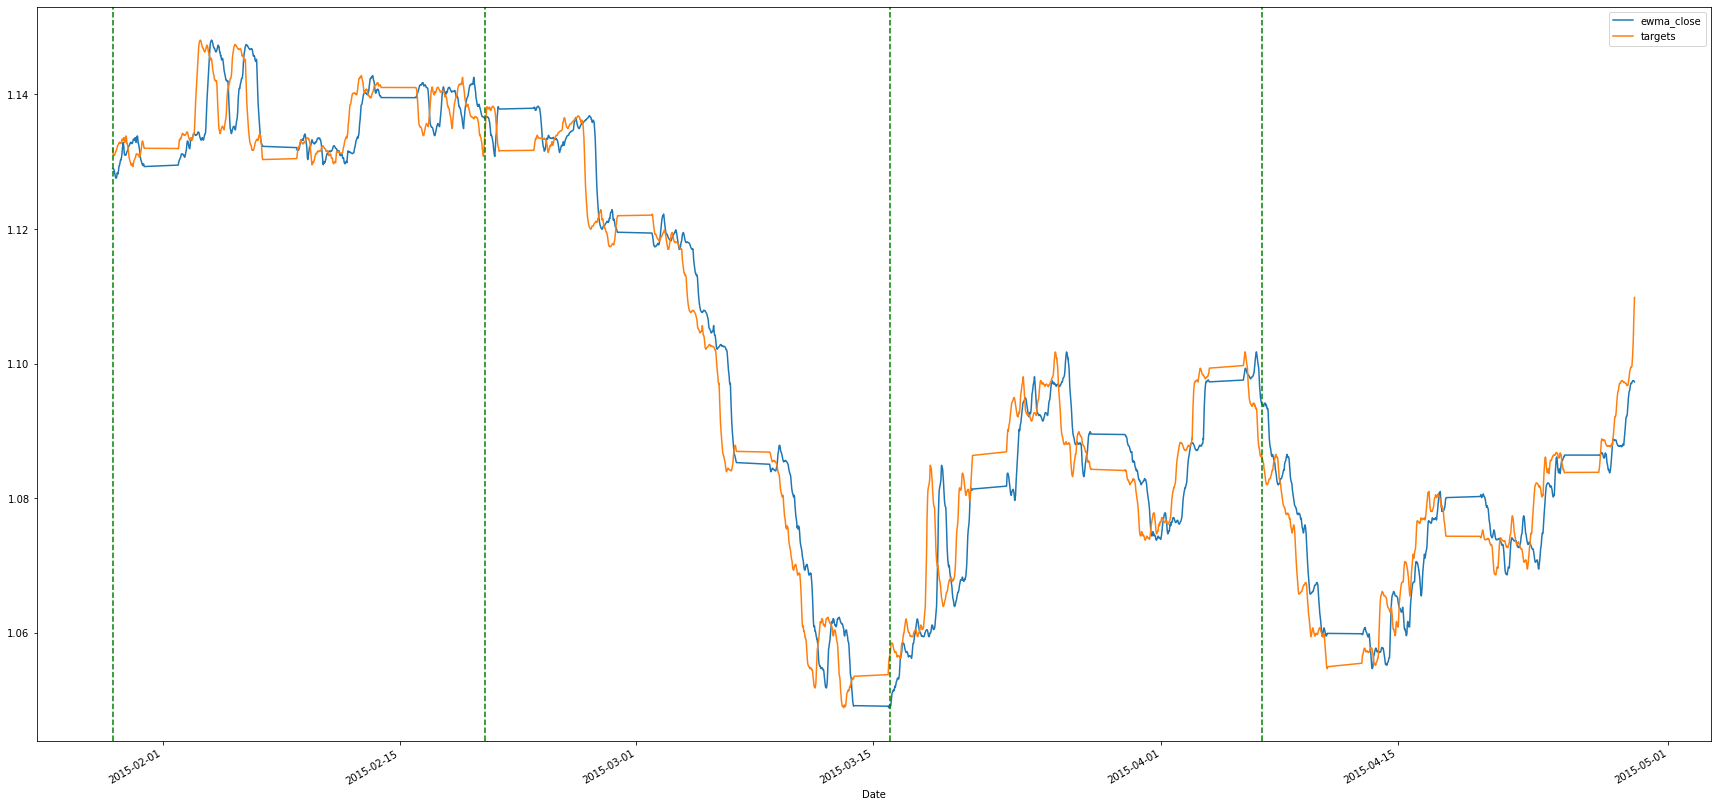

In [163]:
offset=300
period_num=4
ax=df[offset:offset+period_num*look_back].plot(figsize=(30,15))
for i in range(period_num):
    ax.axvline(df.index[offset+i*look_back], color="green", linestyle="--")

In [164]:
df_targets=df["ewma_close"]
x_data=df["targets"].values[0:-shift_steps]
print(type(x_data))
print("shape:", x_data.shape)

<class 'numpy.ndarray'>
shape: (15516,)


In [165]:
y_data=df_targets.values[0:-shift_steps]
print(type(y_data))
print("shape:", y_data.shape)

<class 'numpy.ndarray'>
shape: (15516,)


In [166]:
train_split = 0.9

In [167]:
num_data = len(x_data)

In [168]:
num_train = int(train_split * num_data)
num_train

13964

In [169]:
num_test = num_data - num_train
num_test

1552

In [170]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

15516

In [171]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

15516

In [172]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 1.0488822581474293
Max: 1.1480669805119457


In [173]:
x_scaler = MinMaxScaler()
x_train_reshaped = x_train.reshape(-1,1)
x_train_scaled = x_scaler.fit_transform(x_train_reshaped)

In [174]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [175]:
x_test_reshaped=x_test.reshape(-1,1)
x_test_scaled = x_scaler.transform(x_test_reshaped)

In [176]:
y_scaler = MinMaxScaler()
y_train_reshaped = y_train.reshape(-1,1)
y_test_reshaped = y_test.reshape(-1,1)
y_train_scaled = y_scaler.fit_transform(y_train_reshaped)
y_test_scaled = y_scaler.transform(y_test_reshaped)

In [177]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(13964, 1)
(13964, 1)


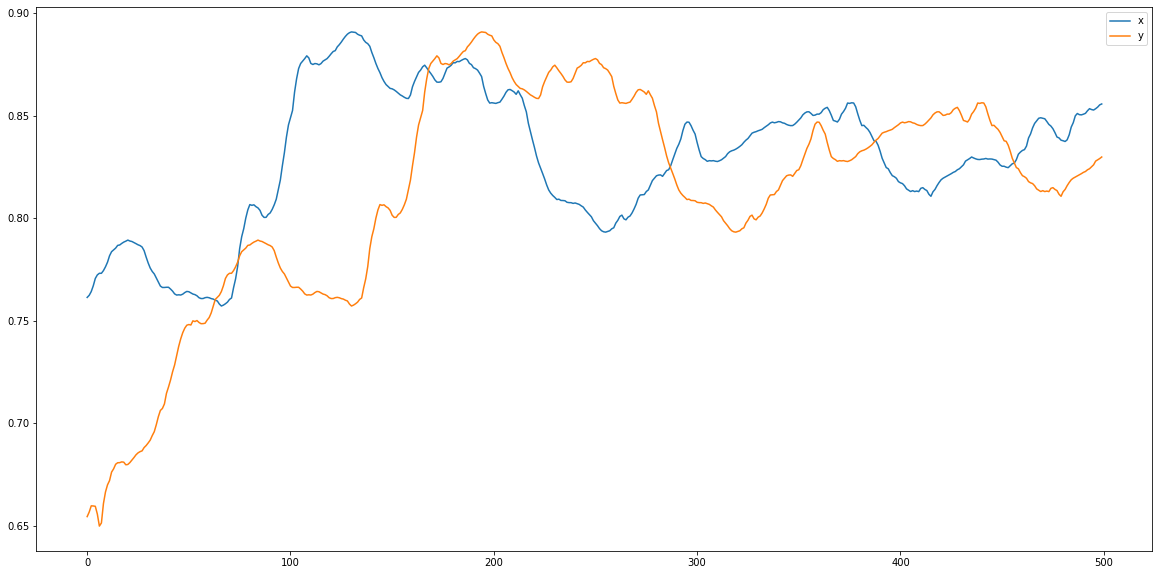

In [178]:
def printXYData(x,y, start=0, end=200):
    x_re=x.reshape(1,-1)[0]
    y_re=y.reshape(1,-1)[0]
    pd.DataFrame(data={"x":x_re[start:end], "y":y_re[start:end]}).plot(figsize=(20,10))


printXYData(x_train_scaled, y_train_scaled, 0, 500)

In [179]:
def createTrainData(inp, output):
    x=[]
    y=[]
    for i in range(look_back, inp.shape[0]):
        x.append(inp[i-look_back:i])
        y.append(output[i-look_back:i])
    return np.array(x), np.array(y)

x_tr, y_tr = createTrainData(x_train_scaled, y_train_scaled)
x_te, y_te = createTrainData(x_test_scaled, y_test_scaled)




In [180]:
validation_data = (x_te, y_te)

In [181]:
model = Sequential()
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, 1,)))
# model.add(Dense(num_y_signals, activation='sigmoid'))


init = RandomUniform(minval=-0.05, maxval=0.05)

model.add(Dense(1, activation='linear', kernel_initializer=init))

In [182]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """
    # print(y_pred[0][0][0])
    # print(y_true.numpy())
    # print(y_pred.numpy())

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]
    # print(y_true, y_pred)
    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [183]:
optimizer = Adam(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [184]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, None, 512)         791040    
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           513       
Total params: 791,553
Trainable params: 791,553
Non-trainable params: 0
_________________________________________________________________


In [185]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)                           
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.5,
                                       min_lr=1e-9,
                                       patience=3,
                                       verbose=1) 
callbacks = [callback_early_stopping,
             callback_reduce_lr]                                                                   

In [186]:
%%time
history=model.fit(x_te, y_te,
          epochs=num_epochs,
          batch_size=64, shuffle=True,
        #   steps_per_epoch=STEPS_PER_EPOCH,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/7
1/1 [==============================] - 1s 1s/step - loss: 0.6076 - val_loss: 0.4240 - lr: 0.0010
Epoch 2/7
1/1 [==============================] - 1s 1s/step - loss: 0.4240 - val_loss: 0.2618 - lr: 0.0010
Epoch 3/7
1/1 [==============================] - 1s 586ms/step - loss: 0.2618 - val_loss: 0.1115 - lr: 0.0010
Epoch 4/7
1/1 [==============================] - 1s 642ms/step - loss: 0.1115 - val_loss: 0.0064 - lr: 0.0010
Epoch 5/7
1/1 [==============================] - 1s 987ms/step - loss: 0.0064 - val_loss: 0.2721 - lr: 0.0010
Epoch 6/7
1/1 [==============================] - 1s 1s/step - loss: 0.2721 - val_loss: 0.0234 - lr: 0.0010
Epoch 7/7
1/1 [==============================] - ETA: 0s - loss: 0.0234
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 [==============================] - 2s 2s/step - loss: 0.0234 - val_loss: 0.0095 - lr: 0.0010
CPU times: user 1min 55s, sys: 33 s, total: 2min 28s
Wall time: 29.5 s


In [187]:
def plotHistory(history):
    fig, ax = plt.subplots(figsize=(30,15))
    ax.plot(history.history['loss'], label='loss (training data)')
    ax.plot(history.history['val_loss'], label='loss (validation data)')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    ax.legend(loc="upper left")
    plt.title(f"loss = {loss}")
    plt.show()

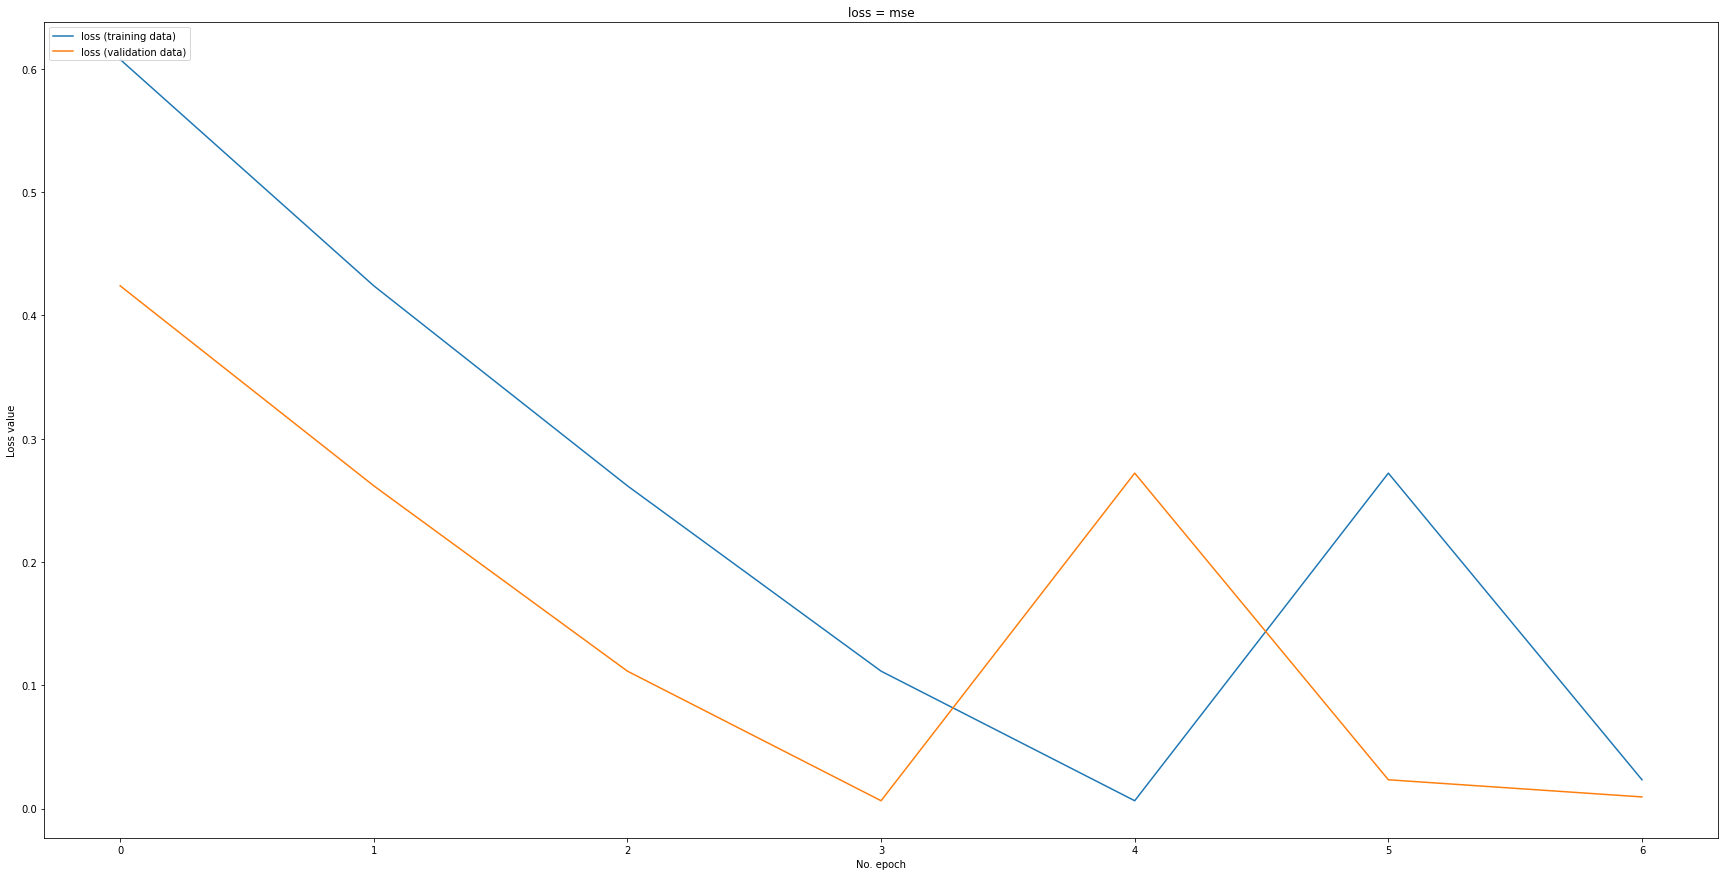

In [188]:
plotHistory(history)

In [189]:
# result = model.evaluate(x=x_te, y=y_te)

In [190]:
print("loss (test-set):", result)

NameError: name 'result' is not defined

In [191]:
def plot_comparison(start_idx, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_tr
        y_true = y_tr
    else:
        # Use test-data.
        x = x_te
        y_true = y_te
    
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx]
    y_true = y_true[start_idx]
    
    # x_orig=x_scaler.inverse_transform(x)

    # Input-signals for the model.
    # x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(np.array([x]))[0]
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    x_rescaled=x_scaler.inverse_transform(x).reshape(1,-1)[0]
    
    y_pred_rescaled = y_scaler.inverse_transform(y_pred)
    
    # Get the output-signal predicted by the model.
    signal_pred = y_pred_rescaled.reshape(1,-1)[0]
    
    # Get the true output-signal from the data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_true)
    signal_true = y_pred_rescaled.reshape(1,-1)[0]
    # Make the plotting-canvas bigger.
    plt.figure(figsize=(30,15))
    
    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
    plt.plot(x_rescaled, label='x')
    
    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
    
    # Plot labels etc.
    plt.ylabel(TARGET_VALUE)
    plt.legend()
    plt.show()

In [192]:
plot_comparison(start_idx=0, train=True)

NameError: name 'TARGET_VALUE' is not defined

In [193]:
plot_comparison(start_idx=20000, train=True)

IndexError: index 20000 is out of bounds for axis 0 with size 12428

In [194]:
plot_comparison(start_idx=200, train=False)

IndexError: index 200 is out of bounds for axis 0 with size 16

In [195]:
plot_comparison(start_idx=2000, train=False)

IndexError: index 2000 is out of bounds for axis 0 with size 16